# SparseEdges : including prior information on first-order distribution of orientations

Natural images show a prototypical distribution of orientation. The goal of this notebook is to study how we could take advantage of this prior information to make the edge extraction even more efficient.

Surprinsingly, we will show that indeed we can make the extraction tuned to that statistics, but that the overall efficiency is not significantly improved.


## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../test

/Users/laurentperrinet/pool/science/BICV/SparseEdges/test


In [3]:
from __future__ import division, print_function
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)
FORMATS = ['pdf', 'eps']

defining framework


In [4]:
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = 'database'
mp.pe.noise = 0.5

print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.62  0.38  0.24  0.15  0.09  0.06  0.03  0.02  0.01  0.01  0.01]


In [5]:
name_database_ = 'serre07_distractors_urban'
name_database_ = 'serre07_distractors'

In [6]:
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


## Running simulations on using the Prior on first-order distribution of orientations

In [7]:
%%writefile ../test/experiment_fig-firstorder.py
# -*- coding: utf8 -*-
from __future__ import division, print_function
"""

$ python experiment_fig-firstorder.py

rm -fr **/prior_* **/**/prior_*
rm -fr **/prior_vanilla* **/**/prior_vanilla*
rm -fr **/prior_vanilla_noise_* **/**/prior_vanilla_noise_*
rm -fr **/prior_firstorder* **/**/prior_firstorder*

"""
import numpy as np
from SparseEdges import SparseEdges

for name_database in ['serre07_distractors']:#, 'serre07_distractors_urban', 'laboratory']:
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.seed = 21341353 # this ensures that all image lists are the same for the different experiments
    mp.pe.N_image = 20
    mp.pe.N = 1024

    # control experiment
    #mp.theta = np.linspace(-np.pi/2, np.pi/2, mp.n_theta+1)[1:]
    imageslist, edgeslist, RMSE = mp.process(exp='prior_vanilla', name_database=name_database)

    imageslist_noise, edgeslist_noise, RMSE_noise = mp.process(exp='prior_vanilla_noise_' + str(mp.pe.noise).replace('.', '_'), name_database=name_database, noise=mp.pe.noise)

    if True:#try:
        six, N, N_image = edgeslist.shape
        # first-order prior
        v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
        v_theta_middles, v_theta_bin  = (v_theta_edges[1:]+v_theta_edges[:-1])/2, v_theta_edges[1]-v_theta_edges[0]
        v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
        v_theta_middles, v_theta_bin  = (v_theta_edges[1:]+v_theta_edges[:-1])/2, v_theta_edges[1]-v_theta_edges[0]

        z = np.linspace(0, 1., mp.pe.n_theta+1)
        P = np.cumsum(np.hstack((0, v_hist[-1]/2, v_hist[:-1], v_hist[-1]/2)))
        
        theta_prior = np.interp(z, P, np.hstack((v_theta_edges[0]-v_theta_bin/2, v_theta_edges[:-1], v_theta_edges[-1]-v_theta_bin/2)))

        mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
        mp.pe.datapath = '../../SLIP/database/'
        mp.pe.seed = 21341353 # this ensures that all image lists are the same for the different experiments
        mp.pe.N_image = 20
        mp.pe.N = 1024
        
        imageslist, edgeslist, RMSE =  mp.process(exp='prior_firstorder', name_database=name_database)
        mp.MP_rho = .994304364466
        imageslist, edgeslist, RMSE = mp.process(exp='prior_quant_firstorder', name_database=name_database)
        mp.MP_rho = None
        imageslist_noise, edgeslist_noise, RMSE_noise = mp.process(exp='prior_firstorder_noise_' + str(mp.pe.noise).replace('.', '_'), name_database=name_database, noise=mp.pe.noise)
    #except:
    #    print('run again once first batches are finished ')

    mp.MP_rho = .994304364466
    imageslist, edgeslist, RMSE = mp.process(exp='prior_quant', name_database=name_database)
    mp.MP_rho = None


Overwriting ../test/experiment_fig-firstorder.py


In [8]:
%run experiment_fig-firstorder.py

## Analysing results on using the Prior on first-order distribution of orientations

First, we retrieve edges from a prior edge extraction

In [9]:
imageslist, edgeslist, RMSE = mp.process(exp='prior_vanilla_noise_' + str(mp.pe.noise).replace('.', '_'), name_database=name_database_)

In [10]:
imageslist, edgeslist, RMSE = mp.process(exp='prior_vanilla', name_database=name_database_)

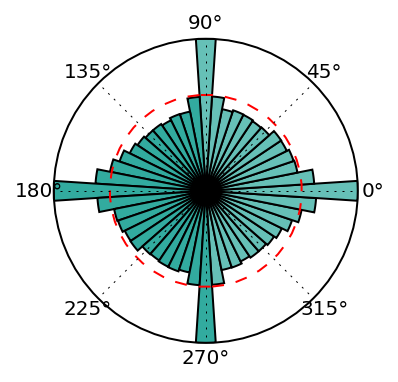

In [11]:
#fig, (a1, a2) = plt.subplots(1, 2)
#fig, a1 = mp.histedges_theta(edgeslist, fig=fig, a=a1)
#fig, a2 = mp.histedges_theta(edgeslist, fig=fig, a=a1)
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
ax = fig.add_subplot(111, axisbg='w', polar=True)
fig, ax = mp.histedges_theta(edgeslist, fig=fig, a=ax)
v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
ax.plot(v_theta_edges, np.ones_like(v_theta_edges)*np.sqrt(v_hist.mean()), 'r--')
ax.plot(v_theta_edges+np.pi, np.ones_like(v_theta_edges)*np.sqrt(v_hist.mean()), 'r--')

for ext in FORMATS: fig.savefig(mp.pe.figpath + 'firstorder_A.' + ext)

In [12]:
v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
v_theta_middles, v_theta_bin  = (v_theta_edges[1:]+v_theta_edges[:-1])/2, v_theta_edges[1]-v_theta_edges[0]

In [13]:
print ('angles for the edges of bins (deg) = ', v_theta_edges*180/np.pi)
print ('angles for the middle of bins (deg) = ', v_theta_middles*180/np.pi)
print ('angles for the center of bins (deg) = ', (v_theta_edges-v_theta_bin/2)*180/np.pi)

angles for the edges of bins (deg) =  [-86.25 -78.75 -71.25 -63.75 -56.25 -48.75 -41.25 -33.75 -26.25 -18.75
 -11.25  -3.75   3.75  11.25  18.75  26.25  33.75  41.25  48.75  56.25
  63.75  71.25  78.75  86.25  93.75]
angles for the middle of bins (deg) =  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5  -0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
angles for the center of bins (deg) =  [-90.  -82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5
  -0.    7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5
  90. ]


Now, we may use this statistics:


In [14]:
z = np.linspace(0, 1., mp.pe.n_theta+1)
P = np.cumsum(np.hstack((0, v_hist[-1]/2, v_hist[:-1], v_hist[-1]/2)))
#theta_prior = np.interp(z, P, v_theta_middles)
#theta_prior = np.interp(z, P, np.hstack((v_theta_edges[-1]-np.pi, v_theta_edges))) #% np.pi
#theta_prior = np.interp(z, P, v_theta_edges-v_theta_bin/2) #% np.pi
theta_prior = np.interp(z, P, np.hstack((v_theta_edges[0]-v_theta_bin/2, v_theta_edges[:-1], v_theta_edges[-1]-v_theta_bin/2))) #% np.pi
#print z.shape, P.shape, P[0], P[-1], theta_prior.shape

In [15]:
z = z[1:]
P = P[1:]
print ('z = ', z)
print ('P = ', P)
#print pe.n_theta, z.shape, P.shape
#print np.hstack((0, np.cumsum(v_hist)))
print ('angles (deg) = ', mp.theta*180/np.pi)
print ('angles (deg) = ', theta_prior*180/np.pi)
#print 'angles (deg) = ', np.interp(z, np.hstack((0, np.cumsum(v_hist))), (v_theta_edges-v_theta_bin/2))*180/np.pi
#print mp.theta.shape, theta_prior.shape
print ('angles (deg) = ', theta_prior[1:]*180/np.pi)

z =  [ 0.04  0.08  0.12  0.17  0.21  0.25  0.29  0.33  0.38  0.42  0.46  0.5
  0.54  0.58  0.62  0.67  0.71  0.75  0.79  0.83  0.88  0.92  0.96  1.  ]
P =  [ 0.05  0.09  0.12  0.15  0.18  0.21  0.24  0.27  0.3   0.34  0.38  0.44
  0.54  0.59  0.63  0.67  0.71  0.75  0.78  0.81  0.84  0.88  0.91  0.95
  1.  ]
angles (deg) =  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
angles (deg) =  [-90.   -87.01 -80.43 -70.44 -59.68 -48.83 -38.25 -28.36 -19.76 -12.38
  -6.47  -2.2    0.79   3.81   9.67  17.04  25.05  33.46  41.98  51.73
  61.45  71.02  80.48  87.01  90.  ]
angles (deg) =  [-87.01 -80.43 -70.44 -59.68 -48.83 -38.25 -28.36 -19.76 -12.38  -6.47
  -2.2    0.79   3.81   9.67  17.04  25.05  33.46  41.98  51.73  61.45
  71.02  80.48  87.01  90.  ]


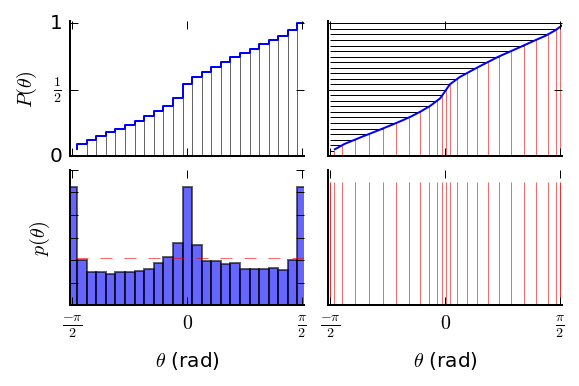

In [16]:
fig, [[B, C], [A, D]] = plt.subplots(2, 2, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'}, sharex=True)
for ax in [A, B, C, D]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#  subplots_adjust(left=None, bottom=None, right=None, top=None,
#                  wspace=None, hspace=None)
#
#The parameter meanings (and suggested defaults) are::
#
#  left  = 0.125  # the left side of the subplots of the figure
#  right = 0.9    # the right side of the subplots of the figure
#  bottom = 0.1   # the bottom of the subplots of the figure
#  top = 0.9      # the top of the subplots of the figure
#  wspace = 0.2   # the amount of width reserved for blank space between subplots
#  hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.1,
                    left=0.125, right=0.9,
                    top=0.9,    bottom=0.175)
A.bar(v_theta_edges-v_theta_bin, np.hstack((v_hist[-1], v_hist)), alpha=.6, width=v_theta_bin)
#A.bar(v_theta_edges[:-1], v_hist, alpha=.6, width=v_theta_bin, align='edge')
A.hlines([v_hist.mean()], [v_theta_edges[0]-v_theta_bin/8.], [v_theta_edges[-1]+v_theta_bin/8.], lw=.5, color='r', linestyle='--', alpha=.6)
plt.setp(A, yticklabels=[], ylabel=r'$p(\theta)$',#xlim=[v_theta_edges[0]-v_theta_bin/4, v_theta_edges[-1]+v_theta_bin/4], 
         #xticks=[-np.pi/2, 0, np.pi/2], xticklabels=[r'$\frac{-\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$'], 
         xticks=[0, np.pi/2], xticklabels=[r'$0$', r'$\frac{\pi}{2}$'], 
         xlabel=r'$\theta$ (rad)')
B.step(v_theta_edges, P, where='pre')
B.vlines(((mp.theta[:-1] + np.pi/2 + v_theta_bin/4)  % np.pi ) - np.pi/2  + v_theta_bin/4, [0], P[1:], lw=.5, color='k', alpha=.6)
plt.setp(B, xticks=[], ylim=[0, 1.02], yticks=[0., 0.5, 1.], yticklabels=['0', r'$\frac{1}{2}$', '1'], ylabel=r'$P(\theta)$')#, xlim=[v_theta_edges[0], v_theta_edges[-1]]
#B.text(-np.pi/2*1.65, 1.05, '(B)')
C.plot(v_theta_edges, P)
C.hlines(z[:-1], [v_theta_edges[0]-v_theta_bin/2], theta_prior[1:], lw=.5)
C.hlines([1], [v_theta_edges[0]-v_theta_bin/2], theta_prior[-1], lw=.5)
C.vlines(theta_prior[1:], [0], z[:-1], lw=.5, color='r', alpha=.6)
C.vlines(theta_prior[-1], [0], [1], lw=.5, color='r', alpha=.6)
#C.text(-np.pi/2*1.1, 1.05, '(C)')
bord = 0.03
plt.setp(C, ylim=[0,1.02], xticks=[-np.pi/2, 0, np.pi/2], xticklabels=['', '', ''], yticks=[0., 0.5, 1.], yticklabels=['', '', ''], xlim=[v_theta_edges[0]-v_theta_bin/2-bord, v_theta_edges[-1]-v_theta_bin/2+bord])#
#D.axis('tight')
#D.vlines((theta_prior + np.pi/2) % np.pi  - np.pi/2, [0], np.ones_like(z), lw=.5, color='r')
D.vlines(theta_prior, [0], np.ones_like(z), lw=.5, color='r', alpha=.6)
D.vlines([-np.pi/2, np.pi/2], [0], np.ones_like(z), lw=.5, color='r', alpha=.6)
#D.vlines(((mp.theta[:-1] + np.pi/2 + v_theta_bin/2)  % np.pi ) - np.pi/2  - v_theta_bin/2, [0], np.ones_like(z), lw=.5, color='k', alpha=.6)
#D.plot(theta, np.ones_like(z), ms='^', lw=0, color='r')
plt.setp(D, ylim=[0, 1.1], yticks=[], xlim=[v_theta_edges[0]-v_theta_bin/2-bord, v_theta_edges[-1]-v_theta_bin/2+bord], 
         xticks=[-np.pi/2, 0, np.pi/2], xticklabels=[r'$\frac{-\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$'], 
         #xticks=[0, np.pi/2], xticklabels=[r'$0$', r'$\frac{\pi}{2}$'], 
         xlabel=r'$\theta$ (rad)')
#D.text(-np.pi/2*1.1, 1.35, '(D)')
for ext in FORMATS: fig.savefig(mp.pe.figpath + 'laughlin.' + ext)

 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
 - Adding parameter "rho"
rho= 0.994021043731 , +/-  0.00482492974419


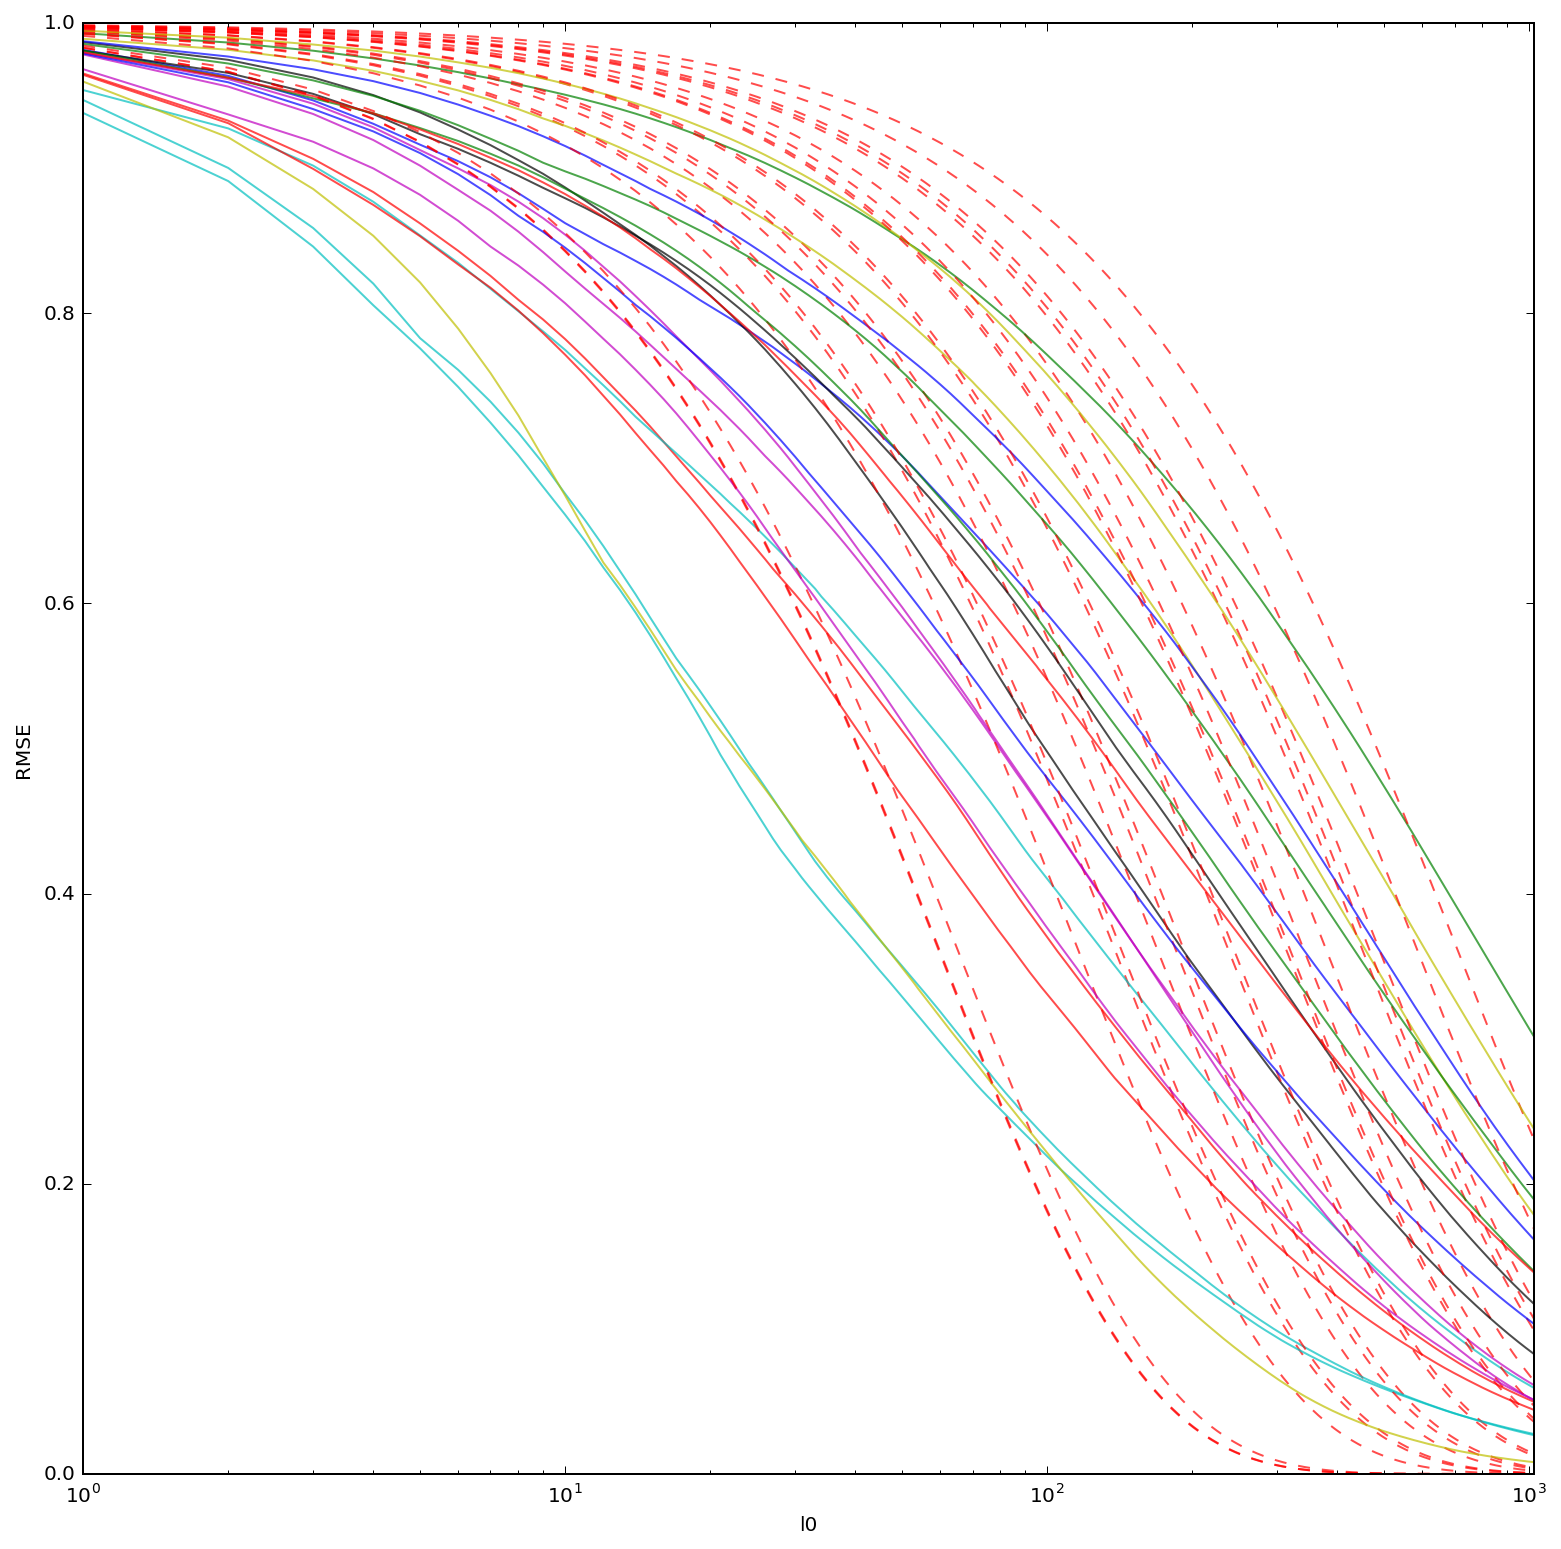

In [17]:
fig, A = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
#mod = PowerLawModel()
mod = ExpressionModel('rho**x')
RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
rho = np.zeros(RMSE.shape[0])
for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'rho':.99}
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=False)
    #print(out.fit_report(min_correl=0.25))
    rho[i_image] =  out.params.get('rho').value
    #print 'rho=', rho[i_image]
    #N_theta = np.log(threshold)/np.log(rho)
    #print N_theta
    A.semilogx( RMSE[i_image, :], alpha=.7)
    params = mod.make_params(rho=rho[i_image])
    A.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    A.set_xlabel('l0')
    A.axis('tight')
    A.axis('tight')
    _ = A.set_ylabel('RMSE')            

print ('rho=', rho.mean(), ', +/- ', rho.std())

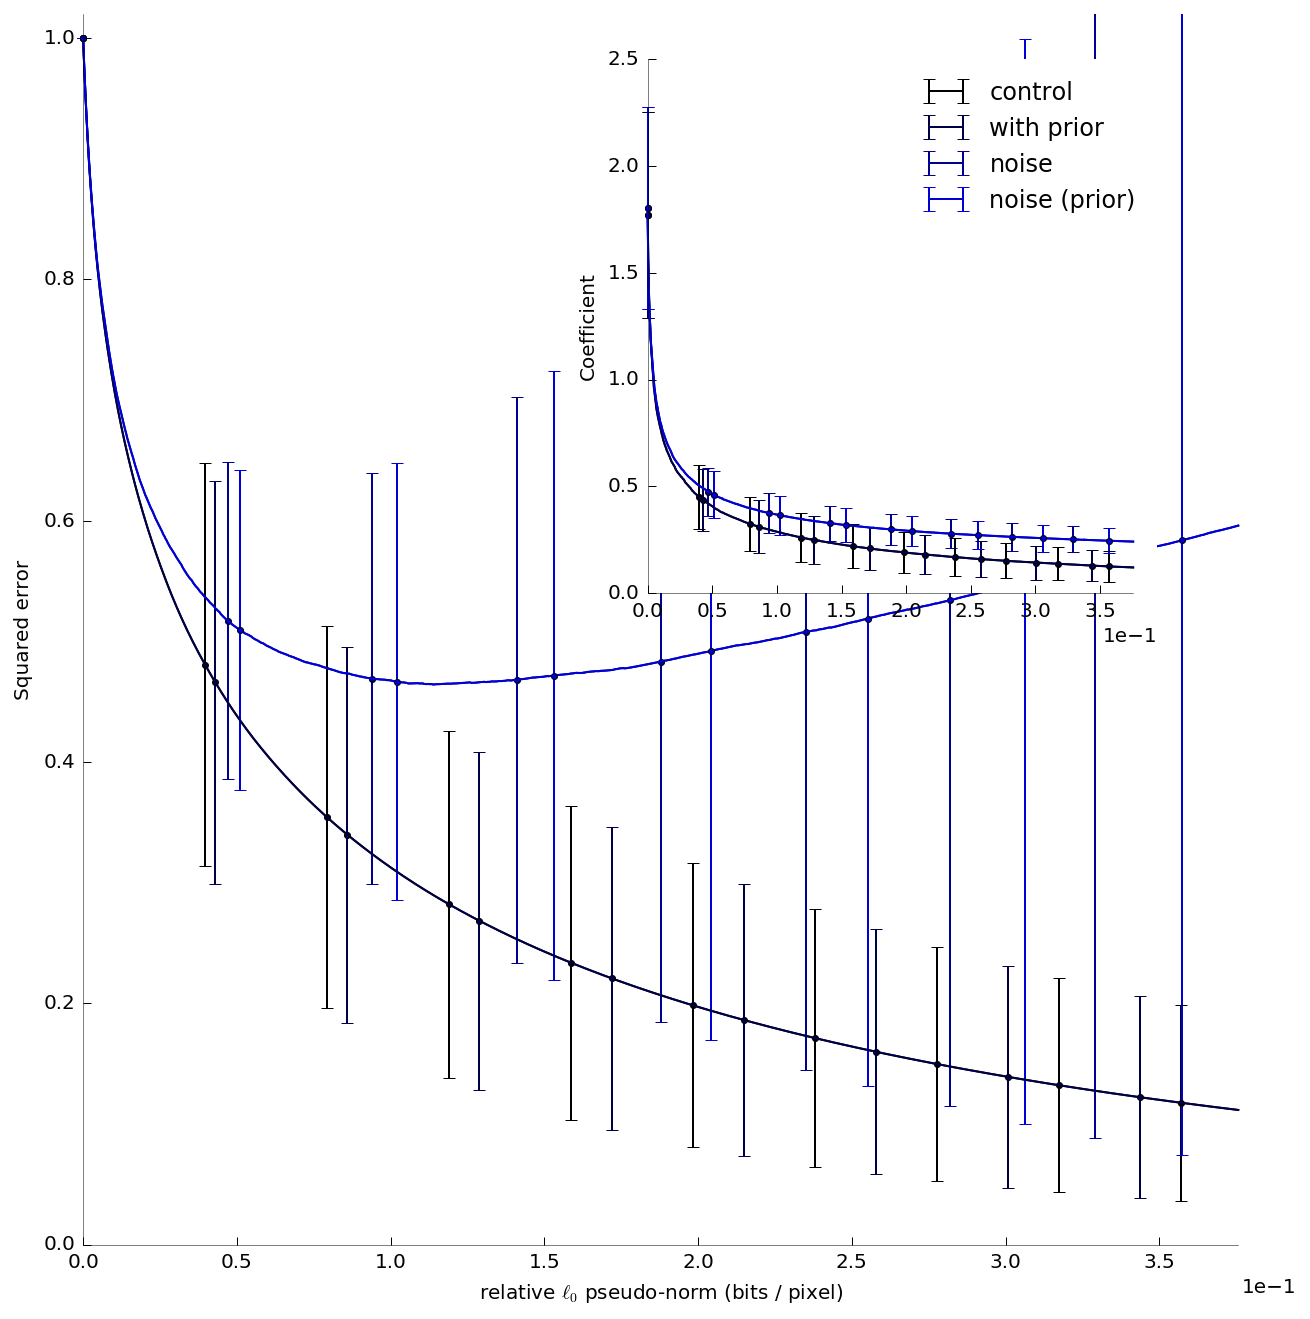

In [18]:
FORMATS = ['pdf', 'eps']
experiments = ['prior_vanilla', 'prior_firstorder', 'prior_vanilla_noise_' + str(mp.pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(mp.pe.noise).replace('.', '_')]
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior', 'noise', 'noise (prior)']
mps = [mp] * len(experiments)
fig_width = 15
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], scale=True)#  


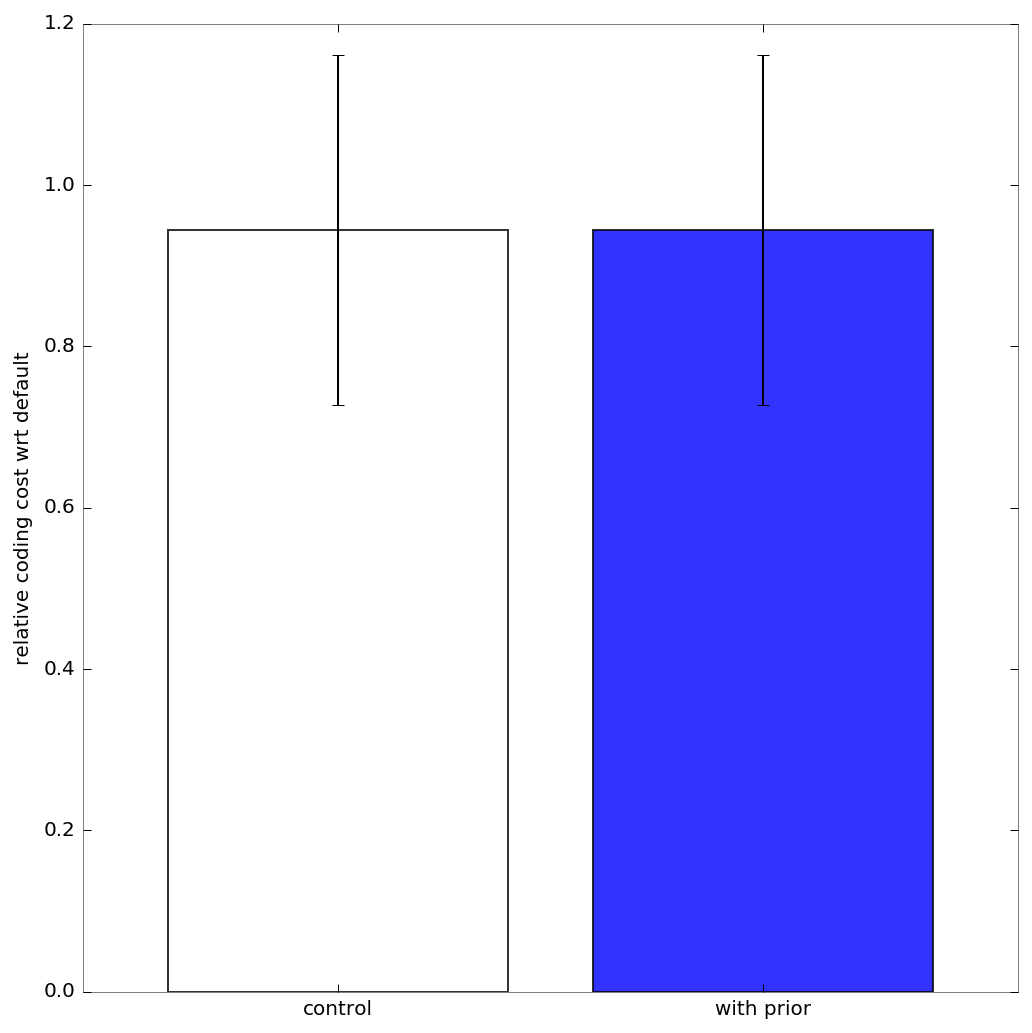

In [19]:
experiments = ['prior_vanilla', 'prior_firstorder']
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.3, ref=0, scale=True)#  


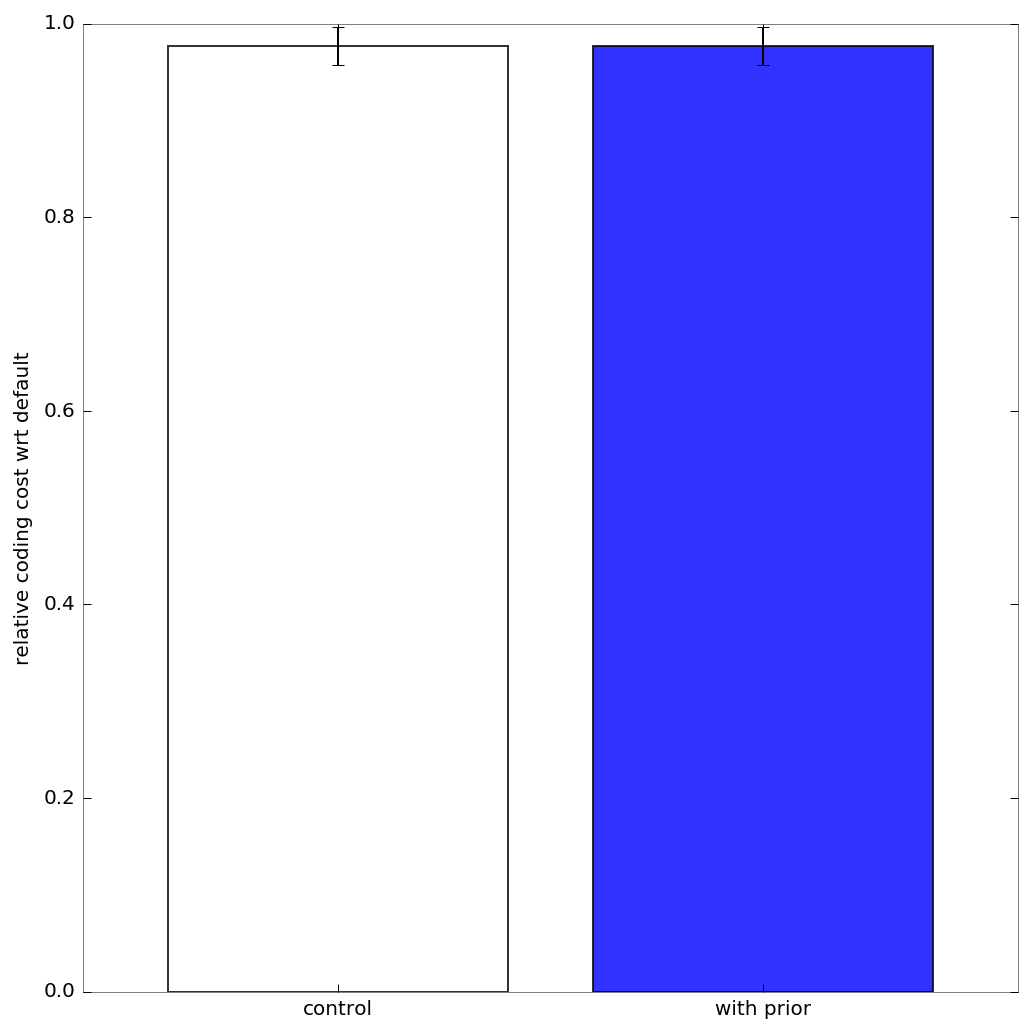

In [20]:
experiments = ['prior_quant', 'prior_quant_firstorder']
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.6, ref=0, scale=True)#  , threshold=0.3, ref=0


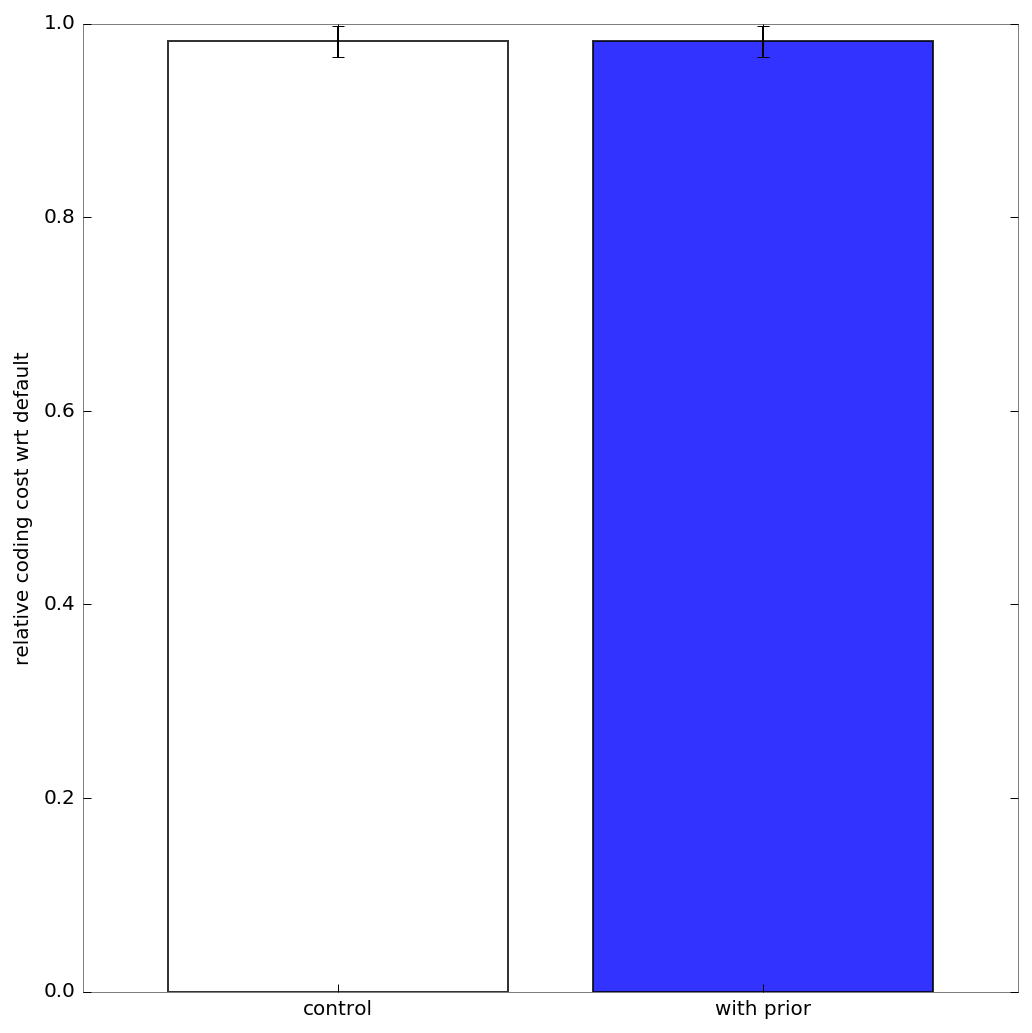

In [21]:
experiments = ['prior_vanilla', 'prior_firstorder']
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.55, ref=0, scale=True)#  


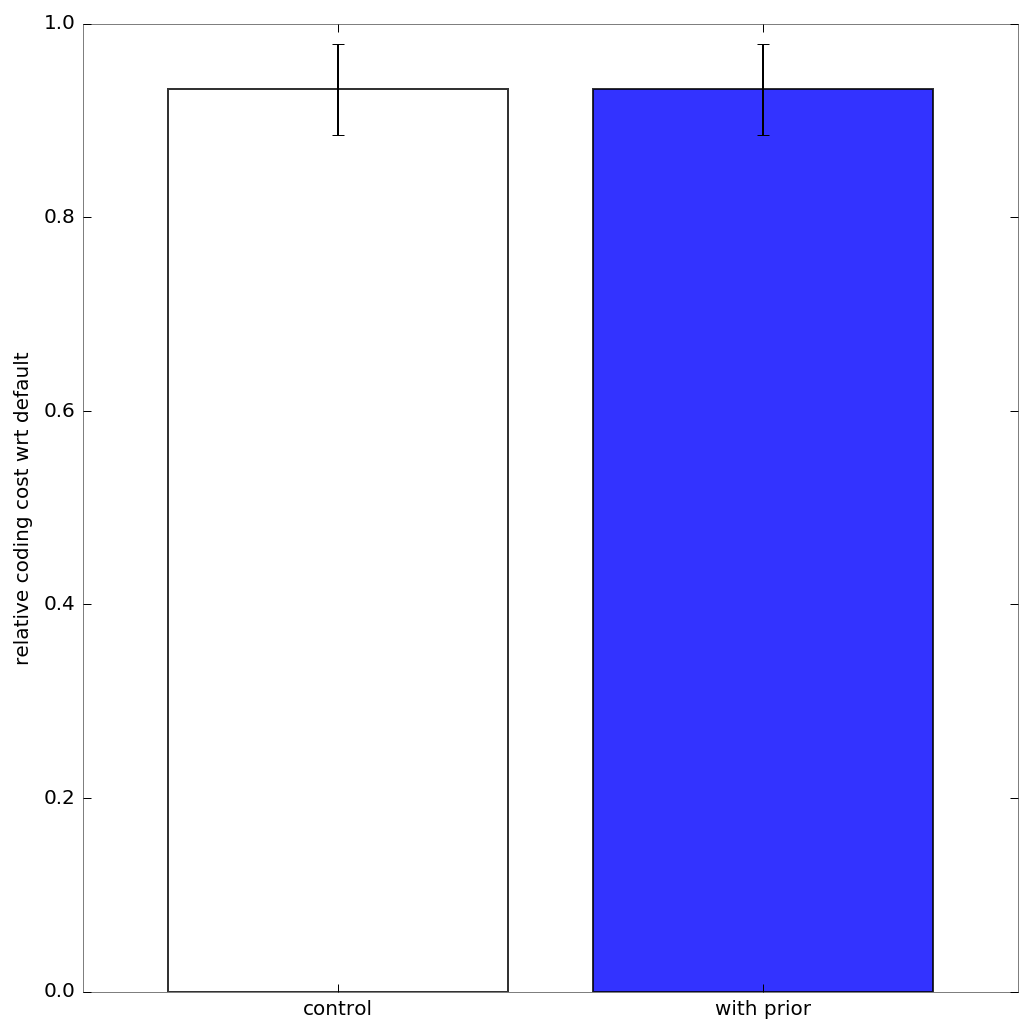

In [22]:
experiments = ['prior_vanilla', 'prior_firstorder']
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.8, ref=0, scale=True)#  


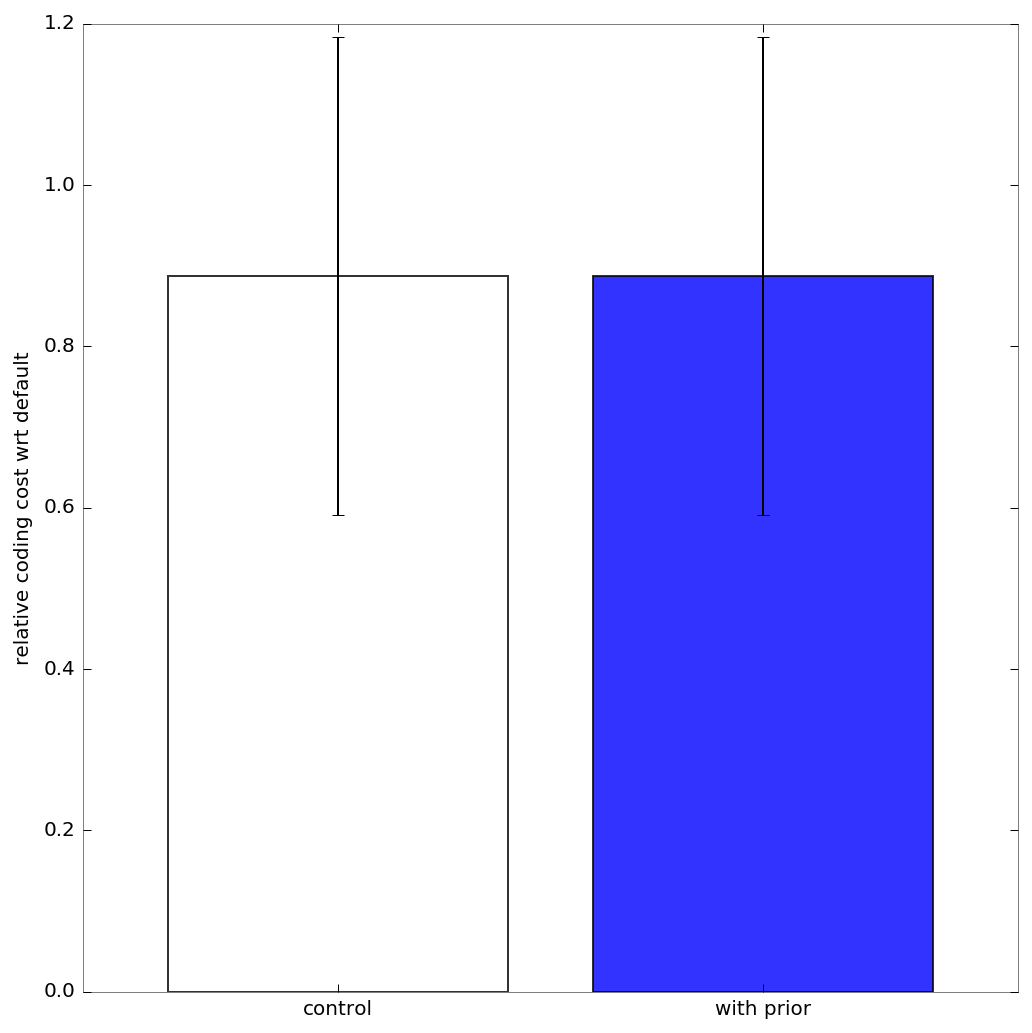

In [23]:
experiments = ['prior_vanilla_noise_' + str(mp.pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(mp.pe.noise).replace('.', '_')]
databases = [name_database_] * len(experiments)
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.5, ref=0, scale=True)#  


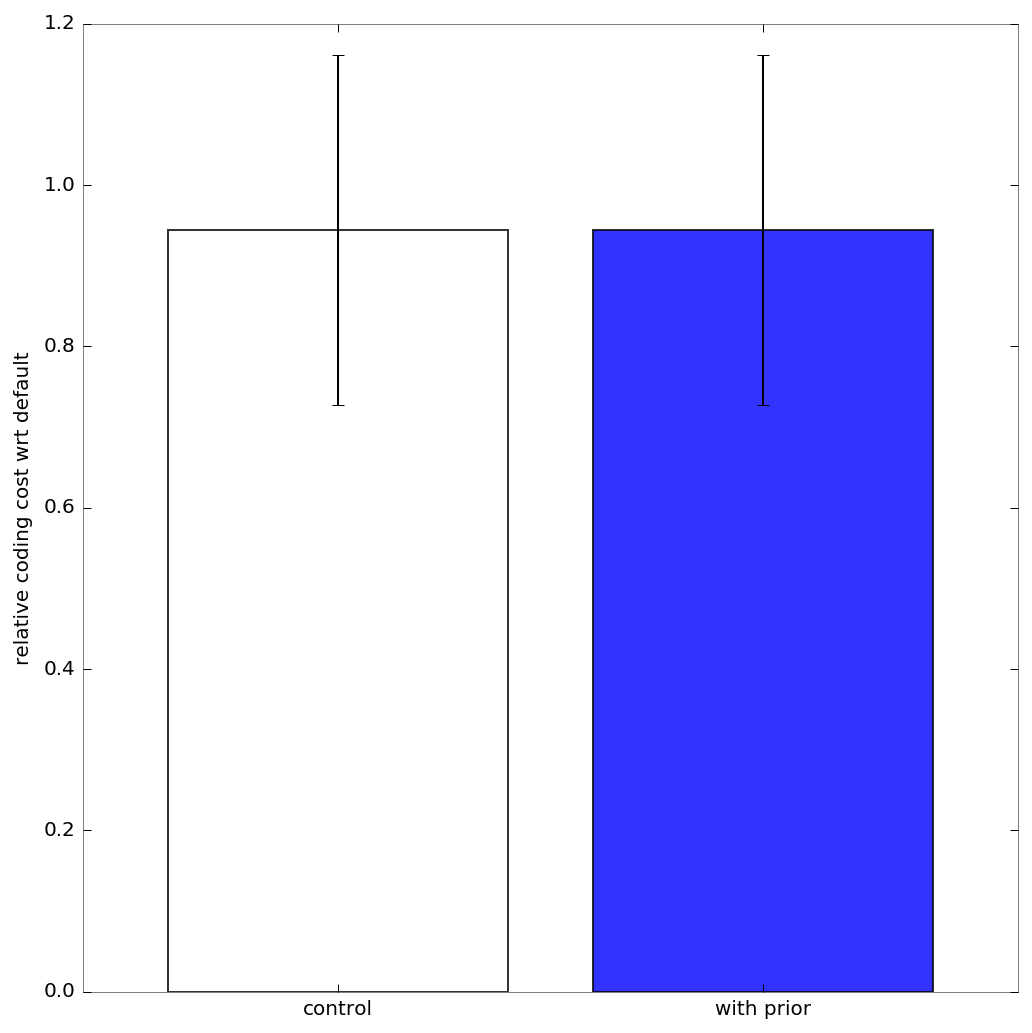

In [24]:
FORMATS = ['pdf', 'eps']
#experiments = ['prior_vanilla', 'prior_firstorder', 'prior_vanilla_noise_' + str(pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(pe.noise).replace('.', '_')]
#experiments = ['prior_vanilla', 'prior_vanilla_noise_' + str(pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(pe.noise).replace('.', '_')]
#experiments = ['prior_vanilla_noise_' + str(pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(pe.noise).replace('.', '_')]
#experiments = ['prior_vanilla_noise_' + str(pe.noise).replace('.', '_'), 'prior_firstorder_noise_' + str(pe.noise).replace('.', '_')]
experiments = ['prior_vanilla', 'prior_firstorder']
databases = [name_database_] * len(experiments)
#databases = ['laboratory'] * len(experiments)
#labels = ['control', 'with prior', 'noise', 'noise (prior)']
#labels = ['control', 'noise', 'noise (prior)']
labels = ['control', 'with prior']
mps = [mp] * len(experiments)
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=mps, experiments=experiments, databases=databases, fig=fig, labels=labels, 
                  color=[0., 0., 1.], threshold=0.3, ref=0, scale=True)#  
for ext in FORMATS: fig.savefig(mp.pe.figpath + 'firstorder_C.' + ext)

In [25]:
imageslist, edgeslist, RMSE = mp.process(exp='prior_vanilla', name_database=name_database_)
v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
v_theta_middles, v_theta_bin  = (v_theta_edges[1:]+v_theta_edges[:-1])/2, v_theta_edges[1]-v_theta_edges[0]
z = np.linspace(0, 1., mp.pe.n_theta+1)
P = np.cumsum(np.hstack((0, v_hist[-1]/2, v_hist[:-1], v_hist[-1]/2)))
theta_prior = np.interp(z, P, np.hstack((v_theta_edges[0]-v_theta_bin/2, v_theta_edges[:-1], v_theta_edges[-1]-v_theta_bin/2))) #% np.pi
print ('angles (deg) = ', theta_prior*180/np.pi)

angles (deg) =  [-90.   -87.01 -80.43 -70.44 -59.68 -48.83 -38.25 -28.36 -19.76 -12.38
  -6.47  -2.2    0.79   3.81   9.67  17.04  25.05  33.46  41.98  51.73
  61.45  71.02  80.48  87.01  90.  ]


In [26]:
imageslist, edgeslist, RMSE = mp.process(exp='prior_firstorder', name_database=name_database_)

angles (deg) =  [-90.   -87.01 -80.43 -70.44 -59.68 -48.83 -38.25 -28.36 -19.76 -12.38
  -6.47  -2.2    0.79   3.81   9.67  17.04  25.05  33.46  41.98  51.73
  61.45  71.02  80.48  87.01  90.  ]
angles (deg) =  [-88.51 -83.72 -75.44 -65.06 -54.25 -43.54 -33.31 -24.06 -16.07  -9.42
  -4.33  -0.7    2.3    6.74  13.36  21.04  29.25  37.72  46.85  56.59
  66.23  75.75  83.75  88.51  91.49]
angles (deg) =  [-88.51 -83.72 -75.44 -65.06 -54.25 -43.54 -33.31 -24.06 -16.07  -9.42
  -4.33  -0.7    2.3    6.74  13.36  21.04  29.25  37.72  46.85  56.59
  66.23  75.75  83.75  88.51  91.49]
[ 0.    0.04  0.06  0.03  0.06  0.03  0.03  0.04  0.04  0.06  0.    0.1   0.
  0.05  0.04  0.04  0.07  0.03  0.03  0.03  0.06  0.04  0.    0.1 ]


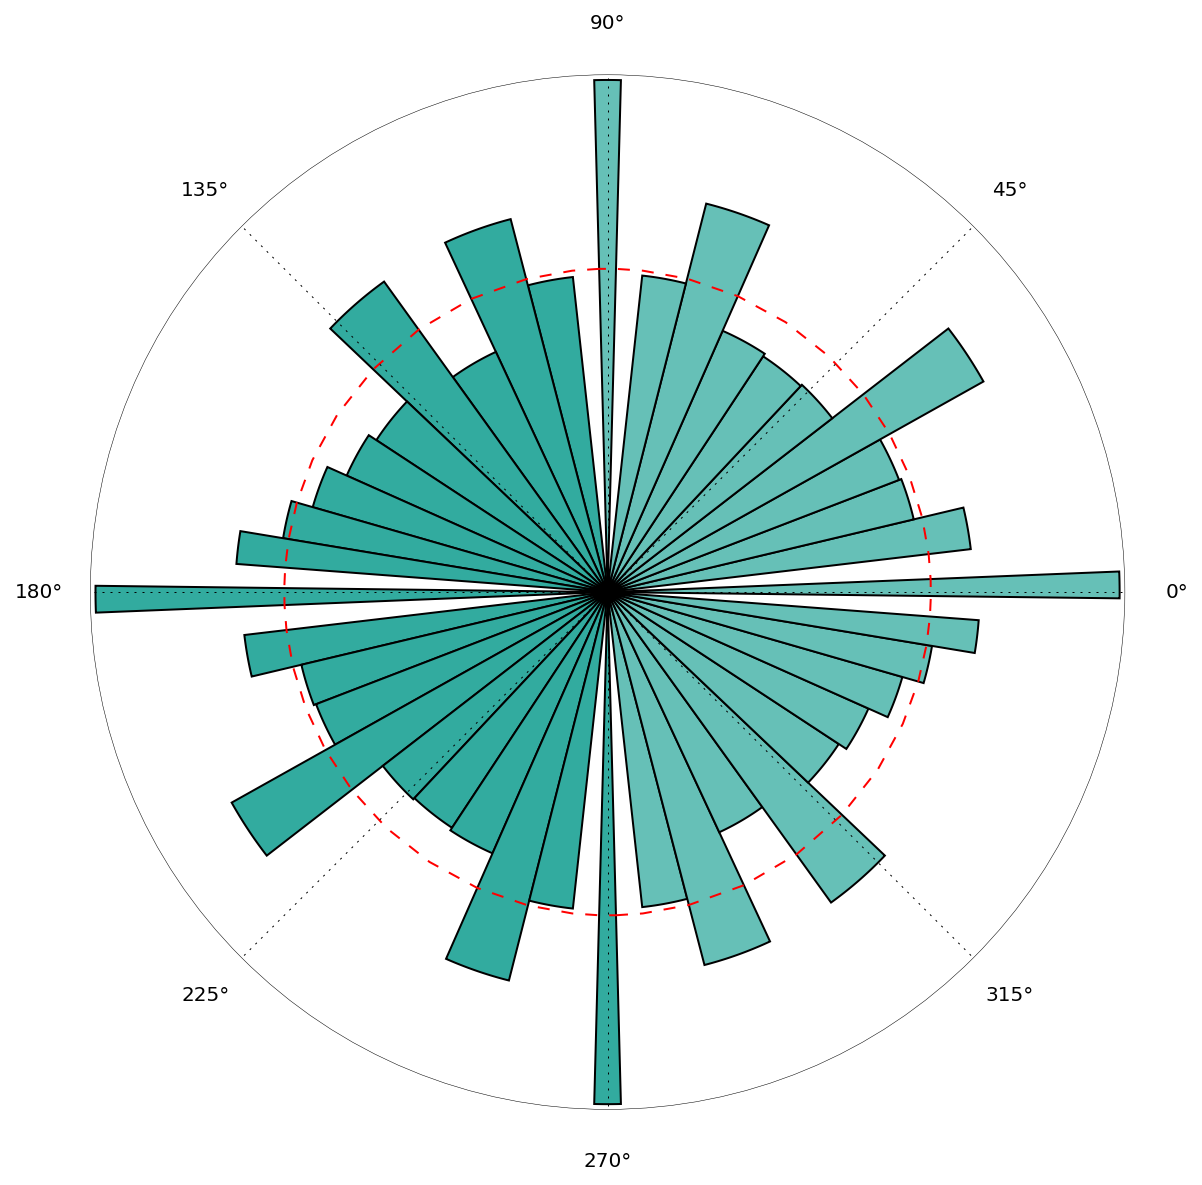

In [27]:
print ('angles (deg) = ', theta_prior*180/np.pi)

#theta_bin = np.linspace(- np.pi/2  + np.pi/mp.pe.N_Dtheta/2, np.pi/2  + np.pi/mp.pe.N_Dtheta/2, 48)
#theta_bin = np.hstack((theta_prior, theta_prior[0]+np.pi)) - np.pi/320#mp.pe.N_Dtheta/2
theta_bin = .5 * (theta_prior[:-1] + theta_prior[1:])
#( np.hstack((theta_prior[-2]-np.pi, theta_prior)) +
 #                 np.hstack((theta_prior, theta_prior[1]+np.pi)) )
theta_bin = np.hstack((theta_bin, theta_bin[0]+np.pi)) 
print ('angles (deg) = ',  theta_bin*180/np.pi)

#theta_firstbin = (theta_bin[1]-theta_bin[0])/2.
#print theta_firstbin*180/np.pi
theta = (edgeslist[2, ...].ravel())
#theta = ((theta + np.pi/2 - np.pi/mp.pe.N_Dtheta/2)  % np.pi ) - np.pi/2  + np.pi/mp.pe.N_Dtheta/2
#print theta.min()*180/np.pi, theta.max()*180/np.pi, (theta.max()-theta.min())*180/np.pi
#theta = ((theta + (np.pi/2 + theta_firstbin) )  % np.pi ) - (np.pi/2  + theta_firstbin)
#print theta.min()*180/np.pi, theta.max()*180/np.pi, (theta.max()-theta.min())*180/np.pi
value = edgeslist[4, ...].ravel()

if False: #mp.pe.edge_mask:
    # remove edges whose center position is not on the central disk
    x , y = edgeslist[0, ...].ravel().real, edgeslist[1, ...].ravel().real
    mask = ((x/mp.N_X -.5)**2+(y/mp.N_Y -.5)**2) < .5**2
    theta = theta[mask]
    value = value[mask]

weights = np.absolute(value)/(np.absolute(value)).sum()

v_hist, v_theta_edges_ = np.histogram(theta, bins=theta_bin, density=False, weights=weights)
print ('angles (deg) = ',  v_theta_edges_*180/np.pi)
print (v_hist)

#plotting
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
ax = fig.add_subplot(111, axisbg='w', polar=True)
#fig, ax = mp.histedges_theta(edgeslist, fig=fig, a=ax)
#v_hist, v_theta_edges = mp.histedges_theta(edgeslist, display=False)
v_hist /= v_hist.mean() # convenience normalization to compare with uniform histogram
ax.bar(v_theta_edges_[1:], np.sqrt(v_hist), width=v_theta_edges_[:-1] - v_theta_edges_[1:], color='#66c0b7')# edgecolor="none")
ax.bar(v_theta_edges_[1:]+np.pi, np.sqrt(v_hist), width=v_theta_edges_[:-1] - v_theta_edges_[1:], color='#32ab9f')
ax.plot(v_theta_edges_, np.ones_like(v_theta_edges_), 'r--')
ax.plot(v_theta_edges_+np.pi, np.ones_like(v_theta_edges_), 'r--')
plt.setp(ax, yticks=[])
for ext in FORMATS: fig.savefig(mp.pe.figpath + 'firstorder_B.' + ext)

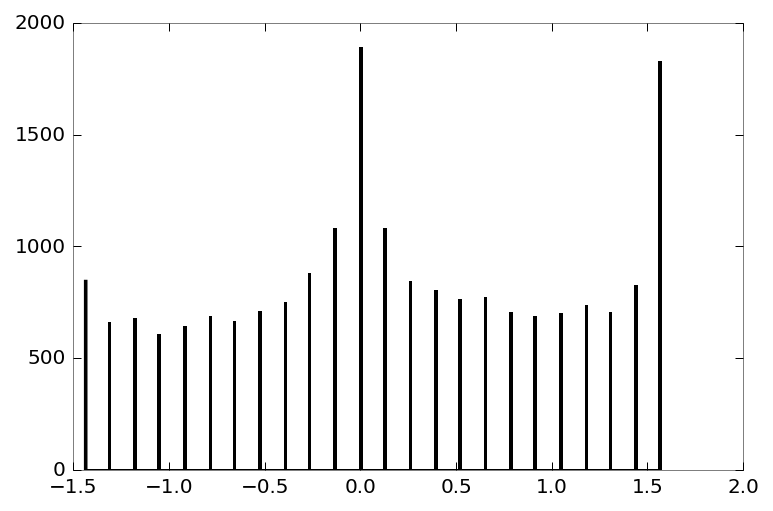

In [28]:
imageslist, edgeslist, RMSE =  mp.process('prior_firstorder', name_database=name_database_)
theta = (edgeslist[2, ...].ravel())
vhist, vbins, patches = plt.hist(theta, bins = 360)

In [29]:
vbins[vhist>0.]*180/np.pi

array([-82.5 , -75.31, -67.65, -60.46, -52.79, -45.12, -37.94, -30.27,
       -22.6 , -15.42,  -7.75,  -0.08,   7.1 ,  14.77,  22.44,  29.63,
        37.29,  44.96,  52.15,  59.81,  67.48,  74.67,  82.33,  89.52])

In [30]:
vhist[vhist>0.]

array([  846.,   659.,   676.,   603.,   640.,   682.,   662.,   707.,
         745.,   878.,  1078.,  1891.,  1078.,   841.,   799.,   761.,
         770.,   700.,   685.,   697.,   734.,   701.,   822.,  1825.])

In [31]:
edgeslist.shape

(6, 1024, 20)

In [32]:
%cd ../notebooks

/Users/laurentperrinet/pool/science/BICV/SparseEdges/notebooks


## some book keeping for the notebook

In [33]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
04/05/2016 11:13:15

CPython 3.5.1
IPython 4.2.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)
system     : Darwin
release    : 15.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [34]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
IPython 4.2.0
OS Darwin 15.4.0 x86_64 i386 64bit
numpy 1.11.0
scipy 0.17.0
matplotlib 1.5.1
sympy 1.0
Wed May 04 11:13:16 2016 CEST